In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
train_df = pd.read_csv('/kaggle/input/nlp-dataset/preprocessed_train.csv')
val_df = pd.read_csv('/kaggle/input/nlp-dataset/prerocessed_validation (1).csv')

# Extract the `phrases` column
train_sentences = train_df['phrases'].tolist()
val_sentences = val_df['phrases'].tolist()

In [4]:
from transformers import DistilBertTokenizer
import random

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

def mask_text(sentences, tokenizer, mask_probability=0.15):
    inputs, labels = [], []
    for sentence in sentences:
        # Tokenize the sentence
        tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

        # Create labels and randomly mask tokens
        input_ids = tokenized["input_ids"][0]
        label_ids = input_ids.clone()

        for i in range(len(input_ids)):
            if random.random() < mask_probability and input_ids[i] != tokenizer.pad_token_id:
                input_ids[i] = tokenizer.mask_token_id  # Replace token with [MASK]
            else:
                label_ids[i] = -100  # Ignore token for loss calculation

        inputs.append(input_ids)
        labels.append(label_ids)

    return {"input_ids": inputs, "labels": labels}

# Prepare datasets
train_data = mask_text(train_sentences, tokenizer)
val_data = mask_text(val_sentences, tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class HinglishDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs[idx],
            "labels": self.labels[idx],
        }


train_dataset = HinglishDataset(train_data["input_ids"], train_data["labels"])
val_dataset = HinglishDataset(val_data["input_ids"], val_data["labels"])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [6]:
from transformers import DistilBertForMaskedLM, AdamW
from transformers import get_scheduler
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

model = DistilBertForMaskedLM.from_pretrained('distilbert-base-multilingual-cased')

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=

In [7]:
epochs = 3
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

Epoch 2: 100%|██████████| 11783/11783 [1:48:44<00:00,  1.81it/s, loss=0.232]  


In [8]:
model.save_pretrained('./hinglish_next_word_model')
tokenizer.save_pretrained('./hinglish_next_word_model')

('./hinglish_next_word_model/tokenizer_config.json',
 './hinglish_next_word_model/special_tokens_map.json',
 './hinglish_next_word_model/vocab.txt',
 './hinglish_next_word_model/added_tokens.json')

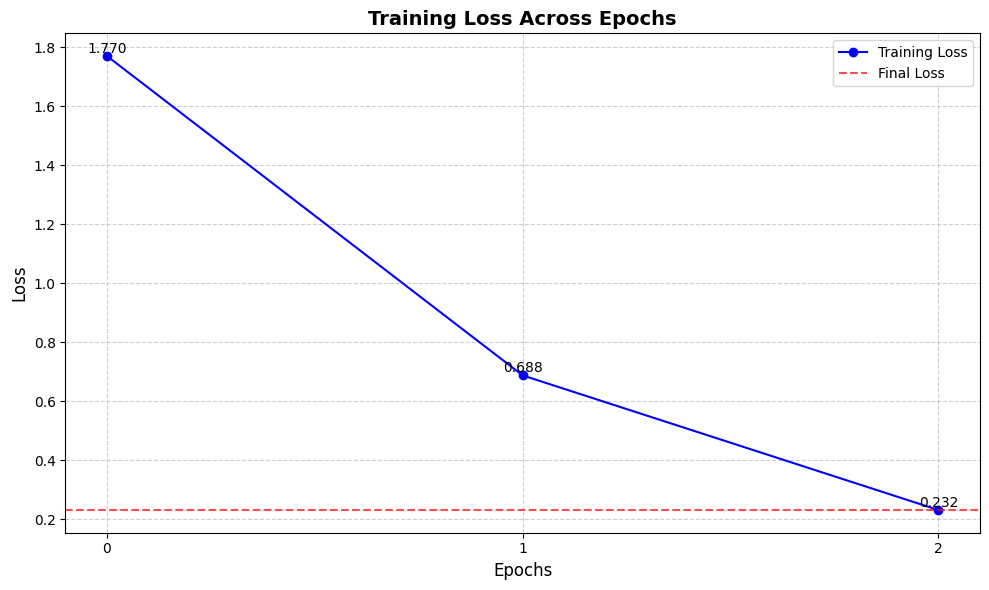

In [14]:
import matplotlib.pyplot as plt

epochs = [0,1,2]
loss_values = [1.77, 0.688, 0.232]

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label="Training Loss")

for epoch, loss in zip(epochs, loss_values):
    plt.text(epoch, loss, f"{loss:.3f}", ha='center', va='bottom', fontsize=10)

plt.title("Training Loss Across Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.axhline(y=loss_values[-1], color='r', linestyle='--', alpha=0.7, label="Final Loss")

plt.legend()
plt.tight_layout()
plt.savefig("improved_loss_graph.png")
plt.show()


In [25]:
from transformers import pipeline

fill_mask = pipeline('fill-mask', model='./hinglish_next_word_model', tokenizer='./hinglish_next_word_model')

def predict_next_word():
    print("Hinglish Next-Word Prediction")
    print("Type a word or sentence to predict the next word.")
    print("Type 'exit' to quit.")

    while True:
        user_input = input("Enter a word or sentence: ").strip()
        if user_input.lower() == 'exit':
            print("Exiting. Goodbye!")
            break

        input_with_mask = f"{user_input} [MASK]"

        try:
            predictions = fill_mask(input_with_mask)
            print("\nPredicted next words:")
            for i, pred in enumerate(predictions):
                print(f"{i+1}. {pred['token_str']} (score: {pred['score']:.4f})")
        except Exception as e:
            print("Error during prediction:", e)
        print()

predict_next_word()

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Hinglish Next-Word Prediction
Type a word or sentence to predict the next word.
Type 'exit' to quit.


Enter a word or sentence:  bahut cute



Predicted next words:
1. hai (score: 0.8065)
2. ho (score: 0.0552)
3. tha (score: 0.0168)
4. karo (score: 0.0147)
5. lagi (score: 0.0101)



Enter a word or sentence:  i want to go home



Predicted next words:
1. now (score: 0.3014)
2. soon (score: 0.2406)
3. late (score: 0.1275)
4. later (score: 0.0945)
5. today (score: 0.0877)



Enter a word or sentence:  ghar



Predicted next words:
1. tak (score: 0.2730)
2. traffic (score: 0.1983)
3. se (score: 0.0765)
4. station (score: 0.0648)
5. par (score: 0.0321)



Enter a word or sentence:  kya hua



Predicted next words:
1. hai (score: 0.6999)
2. he (score: 0.1484)
3. tha (score: 0.0729)
4. traffic (score: 0.0094)
5. ye (score: 0.0062)



Enter a word or sentence:  you seem so



Predicted next words:
1. well (score: 0.4585)
2. happy (score: 0.0450)
3. good (score: 0.0408)
4. great (score: 0.0330)
5. close (score: 0.0263)



Enter a word or sentence:  wapas



Predicted next words:
1. on (score: 0.1216)
2. play (score: 0.1191)
3. music (score: 0.0781)
4. song (score: 0.0747)
5. message (score: 0.0724)



Enter a word or sentence:  ek baar to meri



Predicted next words:
1. ma (score: 0.3560)
2. dil (score: 0.0163)
3. sir (score: 0.0123)
4. run (score: 0.0123)
5. maa (score: 0.0108)



Enter a word or sentence:  call



Predicted next words:
1. karo (score: 0.2822)
2. up (score: 0.2076)
3. me (score: 0.0941)
4. off (score: 0.0864)
5. out (score: 0.0671)



Enter a word or sentence:  exit


Exiting. Goodbye!
